In [2]:
import re
import os
import sys
import csv
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn2
from prettytable import PrettyTable
from matplotlib import pyplot as plt
from Bio import SeqIO, pairwise2, AlignIO
from collections import Counter, namedtuple
from Bio.Align import AlignInfo, MultipleSeqAlignment
import importlib
# importlib.reload(sys.modules['MultipleCutter'])
from Sequence import Sequence
from MultipleCutter import MultipleCutter
from Util.SeqUtil import seqInfo, parseFasta, parseSeqByCutter
from DataStructure import refSeqSimilarityInfo
from Evaluation.DfamEvaluation import DfamEvaluation
from SharedInfo import currDatasetName, cutterA, cutterB, colorA, colorB
from Util.AnalysisUtil import listToSortedCounter, getStatisticData, mostCommonTable
from Util.PlotUtil import basicPlot, twoLabelBasicPlot, lengthScatterDistributionPlot

In [3]:
seqA = Sequence(cutterA)
parseFastaA = seqA.parseFasta()
fragmentLenListA, fragmentSeqListA = seqA.parseSeqByCutter()
repeatInfoListA = seqA.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoA = seqA.filterRepeatInfo()
repeatPositionListA = seqA.getRepeatPositionList(filter=True)
seqAState = seqA.seqStateGenerator()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.1345531940460205 sec to parse fasta file ...
...start parse seq by cutter: GATCC
...cost 0.733820915222168 sec to cut sequence
... start finding repeat seq ...
...cost0.026568889617919922 sec to finding repeat seq  ...


In [4]:
seqB = Sequence(cutterB)
parseFastaB = seqB.parseFasta()
fragmentLenListB, fragmentSeqListB = seqB.parseSeqByCutter()
repeatInfoListB = seqB.findRepeatSeqs(lengthLimit=False)
filterRepeatInfoB = seqB.filterRepeatInfo()
repeatPositionListB = seqB.getRepeatPositionList(filter=True)
seqBState = seqB.seqStateGenerator()

...start parsing dm6/chrX_sequence.fasta fasta file ...
...cost0.11504507064819336 sec to parse fasta file ...
...start parse seq by cutter: AAGCTT
...cost 1.0047438144683838 sec to cut sequence
... start finding repeat seq ...
...cost0.005909919738769531 sec to finding repeat seq  ...


In [5]:
seqInfo(currDatasetName, parseFastaA)

dm6/chrX_sequence dataset
 number of sequence:1
 total length:23542271



In [6]:
# repeat position
multipleCutter = MultipleCutter(sequence=parseFastaA[0], seqStateList = [seqAState, seqBState])
seqStateSum = multipleCutter.getSeqStateSum()
unMatchState, unionState, intersectionState = multipleCutter.getSeqStateInfo()
stateName="intersection"
matchStateIdxList = multipleCutter.getSpecificStateIdxList(stateName)
matchStateRepeatInfoList = multipleCutter.getSpecificStatePositionList()

chr: 23542271
unMatch: 23180167, union:362104, intersection:52820


In [7]:
totalRepeat = multipleCutter.cutRepeatSeqToFragment()
multipleCutter.fragmentGroupbyLen()

...start parse seq by cutter: AAGCTT
...cost 0.00017118453979492188 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 0.00016999244689941406 sec to cut sequence
...start parse seq by cutter: GATCC
...cost 0.00011491775512695312 sec to cut sequence
...start parse seq by cutter: GATCC
...cost 4.792213439941406e-05 sec to cut sequence
...start parse seq by cutter: GATCC
...cost 0.0001380443572998047 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 0.0003399848937988281 sec to cut sequence
...start parse seq by cutter: GATCC
...cost 2.8848648071289062e-05 sec to cut sequence
...start parse seq by cutter: GATCC
...cost 0.00010895729064941406 sec to cut sequence
...start parse seq by cutter: GATCC
...cost 0.00011181831359863281 sec to cut sequence
...start parse seq by cutter: AAGCTT
...cost 0.00011897087097167969 sec to cut sequence
...start parse seq by cutter: GATCC
...cost 2.9087066650390625e-05 sec to cut sequence
...start parse seq by cutter: GATCC
...cos

In [8]:
# tem = pd.DataFrame(totalRepeat, columns=['length','startIdx', 'endIdx', 'seq'])
# totalRepeat.sort_values(['length'])

In [9]:
# # From Here 驗證 frgment 切割位置
# # parseFastaA[0][1035674:1035687]

# # GATC
# # A 

# # GATC
# # CC

# # GATC
# # G

# # GATC
# # CAAC

# # GATC

# # startIdx = 0
# # (0, 1, 2, 1, 4, 0)


# # (0, 8) #startIdx = startIdx + cutterlen * (fragmentIdx-1) , endIxd = startIdx + cutterlen * ( fragmentIdx + 1 )
# # (5, 14) #startIdx+
# # (11, 19)

# temSeq = 'GATCAGATCCCGATCGGATCCAACGATC'
# fragmentsLenList, fragmentsSeqList = parseSeqByCutter([temSeq], cutter=cutterA)
# print("fragmentsLenList",fragmentsLenList)
# print("fragmentsSeqList",fragmentsSeqList)
# cutterLen = len(cutterA)

# for idx, seqFragmentLengthList in enumerate(fragmentsLenList):
#     startIdx = 0
#     for fragmentIdx, fragmentLength in enumerate(seqFragmentLengthList):
#         if fragmentLength > 0:
#             start = startIdx + sum(seqFragmentLengthList[:fragmentIdx]) + cutterLen * (fragmentIdx-1)
#             end = startIdx + sum(seqFragmentLengthList[:fragmentIdx+1]) + cutterLen * (fragmentIdx+1)
#             print("start", start, "end", end)
#             print("seq", temSeq[start:end])
#             # print("seqFragmentLengthList", sum(seqFragmentLengthList[idx][:fragmentIdx] ))
           

In [10]:
# # # [ Output GroupByData File ]
# df= pd.DataFrame(matchStateRepeatInfoList, columns=['length', 'startIdx', 'endIdx', 'seq'])
# matchDfGroupByLen = df.groupby(by=["length"], sort=True)
# tem = df.groupby(by=["length"]).agg({"length": "sum"})

# original_stdout = sys.stdout
# with open(f'../outputFile/SeqState/seqGroupByLenData_{stateName}_Cutter_{cutterA}.txt', 'w') as f:
#     sys.stdout = f
#     for key, row in tem.iterrows():
#         print(f"{key}:")
#         for i in matchDfGroupByLen.get_group(key).index:
#             print(f"({ df.iloc[i]['startIdx']}, {df.iloc[i]['endIdx']})\n{ df.iloc[i]['seq']}")
#         print("\n")
#     sys.stdout = original_stdout

In [11]:
# [ Output SeqState File ]
# multipleCutter.generateSeqStateSumFile(filePath = '../outputFile/SeqState/seqStateSum.txt')

In [12]:
# [ Mltiplecutter, Intersection or Union ]
dfam = DfamEvaluation(matchStateRepeatInfoList, hitFileName='cheX_BS2_dm6_dfam.nrph.hits')
repeatPositionLookupDic = dfam.positionBucketClassifier()
dfamPositionList = dfam.getDfamPositionList()

# from Dfam , check repeat
DRrepeatMatchList, DRmatchedFamilyAccList, DRmatchedFamilyNameList = dfam.checkDfamMatchWithRepeat()

# from repeat , check Dfam
RDrepeatMatchList, RDmatchedFamilyAccList, RDmatchedFamilyNameList = dfam.checkRepeatMatchWithDfam()

# dfam.familyMatchRatio(DRmatchedFamilyAccList)
dfam.matchRatio(DRrepeatMatchList)
# unMatchDf = dfam.getUnmatchInfo(DRrepeatMatchList)

matchCount:2	dfamCount:31	Ratio:0.06451612903225806


0.06451612903225806

In [13]:
(DRrepeatMatchList)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False]

In [14]:
def getSequenceLengthAnalsis(inputLengthList, num=10):
    """
    1. count of common length 
    2. statistic info
    3. distribution plot
    """
    mostCommonTable(Counter(inputLengthList).most_common(num), num)
    getStatisticData(inputLengthList)
    sortedCounterList = listToSortedCounter(inputLengthList)
    basicPlot(sortedCounterList)

In [15]:
# totalDfam = DfamEvaluation(repeatPositionList, hitFileName="chrX_dm6_dfam.nrph.hits")
# totalRepeatPositionLookupDic = totalDfam.positionBucketClassifier()
# totalDfamPositionList = totalDfam.getDfamPositionList()
# unionAndFilter_Position = pd.read_csv('../outputFile/txtFile/unionAndFilter_Position.csv')
# intersectionAndFilter_Position = pd.read_csv('../outputFile/txtFile/intersectionAndFilter_Position.csv')
# Filter_Position = pd.read_csv('../outputFile/txtFile/Filter_Position.csv')
# NonFilter_Position = pd.read_csv('../outputFile/txtFile/NonFilter_Position.csv')

# unionAndFilter_Counter = listToSortedCounter((unionAndFilter_Position['length']))
# intersectionAndFilter_Counter = listToSortedCounter((intersectionAndFilter_Position['length']))

In [16]:
# df = pd.DataFrame(columns=["x", "y", "type"], dtype=float)
# for row in unionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "unionAndFilter"}, ignore_index=True)
# for row in intersectionAndFilter_Counter:
#     df = df.append({"x": row[0], "y": row[1], "type": "intersectionAndFilter"}, ignore_index=True)

# df.fillna(np.nan, inplace=True)
# fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
# sns.set_style("whitegrid")
# sns.lineplot(data=df, x="x", y="y", hue="type", palette="Set1")
# ax.set_xlabel("Length", size=15)
# ax.set_ylabel("Count", size=15)
# ax.set_xlim(0, 1500)

+---------+-------+
| FragLen | Count |
+---------+-------+
|   2330  |   5   |
|    60   |   2   |
|    66   |   2   |
|   2331  |   2   |
|    59   |   1   |
|    85   |   1   |
|    49   |   1   |
|   227   |   1   |
|   334   |   1   |
|    82   |   1   |
+---------+-------+
count      31.000000
mean      705.935484
std       925.684861
min        49.000000
25%        83.500000
50%       227.000000
75%       981.500000
max      2331.000000
dtype: float64


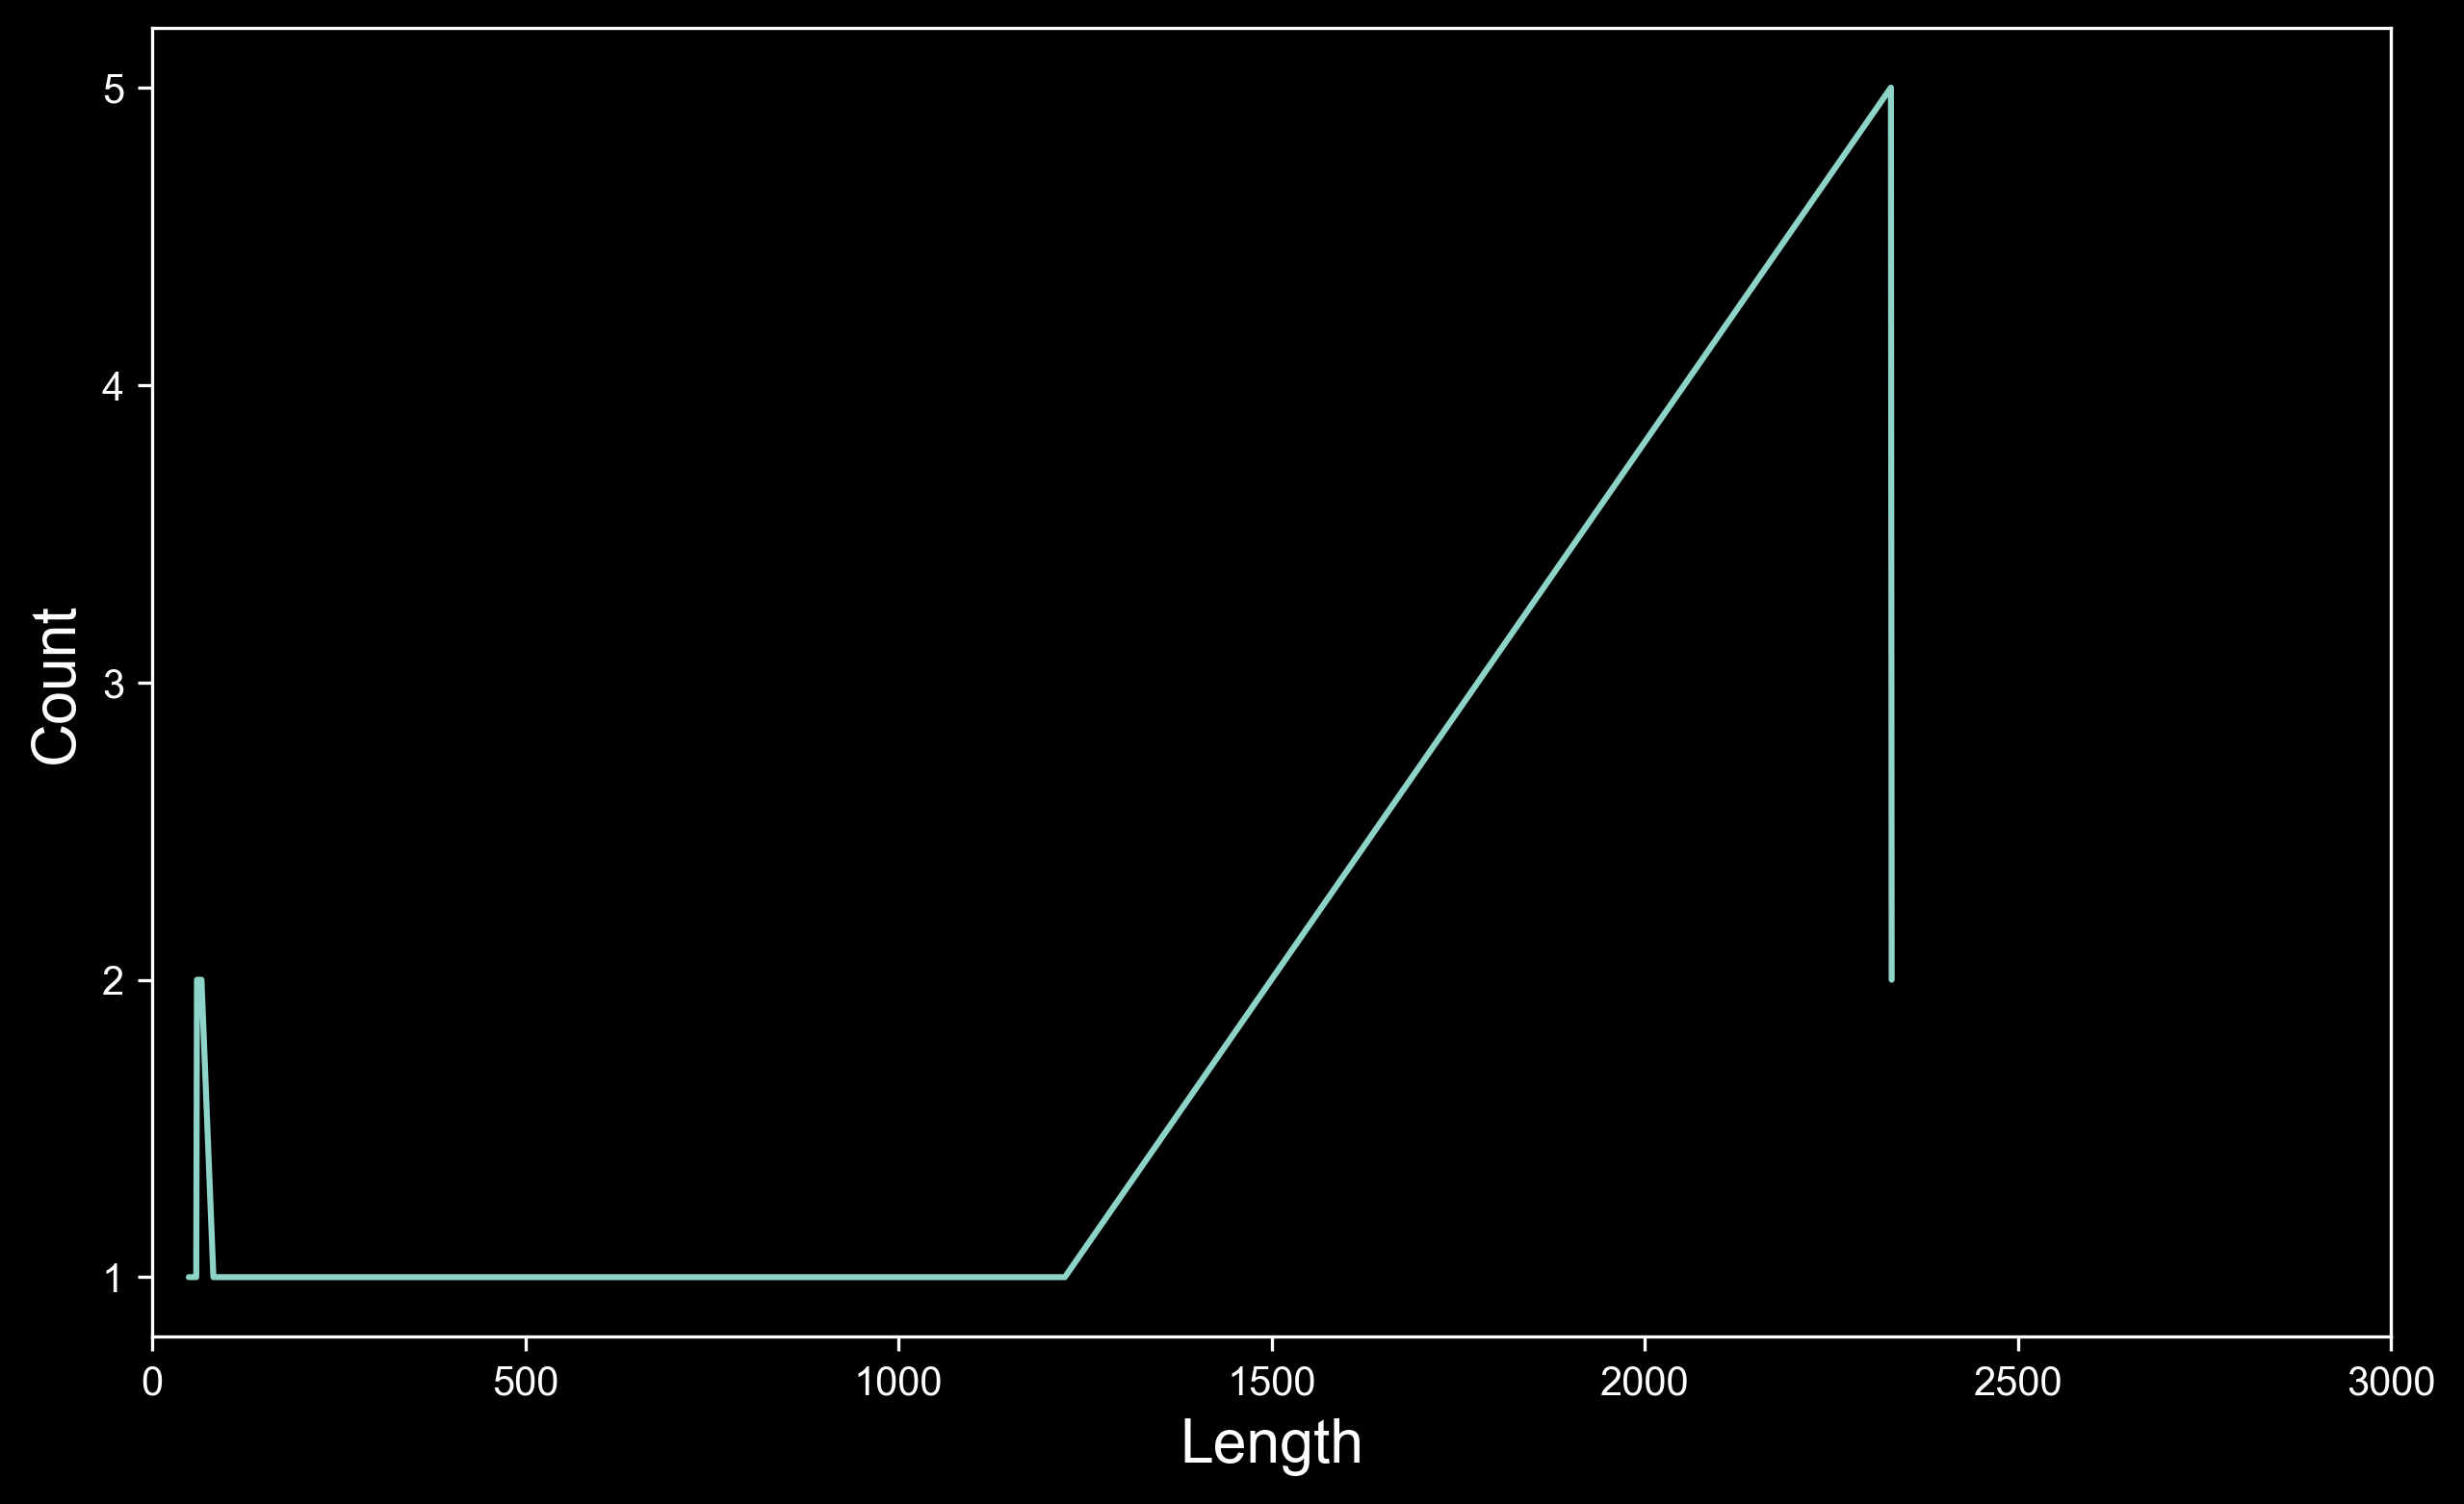

In [17]:
# Dfam ref sequence 
dfamSeqLenList = [ i.endIdx - i.startIdx for i in dfamPositionList ]
getSequenceLengthAnalsis(dfamSeqLenList)

In [18]:
BS2df = pd.DataFrame(columns=['startIdx','endIdx','length','seq'])
for i in dfamPositionList:
    BS2df = BS2df.append({'startIdx': i.startIdx,'endIdx': i.endIdx ,'length':i.endIdx-i.startIdx,'seq': parseFastaA[0][i.startIdx: i.endIdx]}, ignore_index=True)
BS2df.to_csv('./Evaluation/Source/chrX_BS2_ref.csv', index=False)

In [19]:
# Repeat sequence
# repeatFragmentLenList = [ i.endIdx - i.startIdx for i in repeatPositionList ]
# getSequenceLengthAnalsis(repeatFragmentLenList)

In [20]:
alignments = pairwise2.align.globalxx("ACG", "ACCGT")
alignments[0].score / len("ACG")

1.0

In [21]:
def consensusSeqSimilarity(consensusSeq, seqDf):
    seqSimilarityList = []
    for targetSeq in seqDf:
        alignments = pairwise2.align.globalxx(targetSeq, consensusSeq)
        targetLength = len(targetSeq)
        similarityPercentage = round(alignments[0].score / targetLength, 2)
        seqSimilarityList.append(similarityPercentage)
    return seqSimilarityList

# repeatMatchIdxList = []
# for idx, value in enumerate(RDrepeatMatchList):
#     if value == True:
#         repeatMatchIdxList.append(idx)
# repeatBasePositionList = [repeatPositionList[i] for i in repeatMatchIdxList]
# repeatSeqDf = pd.DataFrame(columns=['startIdx','endIdx', 'length', 'seq'])
# for i in repeatBasePositionList:
#     repeatSeqDf = repeatSeqDf.append({'startIdx':i.startIdx ,'endIdx': i.endIdx, 'length': (i.endIdx- i.startIdx), 'seq': str(parseFastaA[0][i.startIdx:i.endIdx])}, ignore_index=True)
conParseFasta = parseFasta(
    "DF0001549_BS2",
    "./Evaluation/Source/DF0001549_BS2.fa",
    "*",
    matchMode=False,
)
consensusSeq = conParseFasta[0].upper()
repeatDf = pd.read_csv('./Evaluation/Source/chrX_BS2_ref.csv')
seqDf = repeatDf["seq"]
seqSimilarityList = consensusSeqSimilarity(consensusSeq, seqDf)
pd.Series(seqSimilarityList).describe()

...start parsing DF0001549_BS2 fasta file ...
...cost0.0007328987121582031 sec to parse fasta file ...


count    31.000000
mean      0.970645
std       0.055253
min       0.870000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64

In [22]:
a = "AAGCTTCTATTATTGGGCTGTTGCTGTTGCTTCTGTTGTTGGTGCGTCAAGCTCAGTGGTTGCTTATGGTGAACGAACCCTGTAACCACATCTGCATACGATATACCTCCTCTAGAAGAGGGGATCTCCCTACCTCCAGATAAGCCCTGTGTAGTTGGTCGCTCCTTTACCTCGGTTCTTCCGGCCACTCCACTTCTGGGTCTGGATCGCTGCATGAACGCTTGTAGTTTGCTGCAACCTTAATAATTTGCAGGATGCTGTCCACCACAGTTGTAGCAAGTGCACAGCTCGATGCGAGGCCTAGTACAGTCCTTGGCTGGGTGTTCGCCGGCACGTTTCACACAAATGTGGGCCTTACGGCAGTATTTGGCTGTGTGGCCAAACTGCTGACAACGATGGCATTGAACAATATCGTTACGCTTGCGGAGAGGCTCAATAAGTACTCTCATATGGCATAGTTACTGTCAGGATCTCCTTATTGTTTGTCGCAGCAGCTTTTGAGGTACCTGGTTCGTTTCGCCTTAGCGGTGTATGTATGTCGAGCACCTTGTGCCCGATATTTTCCAGCTCTTCCTTGATCTGGTAATGTAGCGTACAGTGGTGCAGGCCTTTCACGCATACCCTGTAAGGAATGTCTTCTTTTAGCTGGTAACAGTGGAACTCATATTCTTCGTTCTCGACTTCACTATGATGCGAAATGTGTCAGGACACCGCCCATTGACGCCCTAGCCTCAACCTCAAACTTTTCTATGTCCACTATATTTTCGATGCTCTGCATCATCGTCGTCTACTCCCTCCATTACTATAGGAGGTGGTTTGGACTGCGCCTTGTTGAGTGAGCTAGTGGTACCAGCGGAGGCTGCATCCCGCTTAGCGGCAGCAATAGCAGGTTGGTGACTGGTACTGGGCTGGTCATACAGATCGCCGATATCATTGCCTACTTGTTTGTCGACTGAGAGATGCGCAAGTAAACCAAAAAGGTTAGAGTTGCCGCCATATCTAGGTTCTGTAGACGATGGGTTTTCCCCTTGTTTGCCGATATTTGATTTAGATTTTTCCTGTCAGTCTCCGAAAAAGCACGAGACTTTCGCTTTATTTGAAAGCGCTGCGGGGCAGAACATTGGGGGCTCGAGAAAACCGCAGTAGCCAATGAGTCACCAGATTTCTAGCCAAGACTTGAACCCTAGGATAGAAAAGCTTTGAGCTCACAAATAGCTGTTTGTGCGATCGCGCGGCTGCTGGGCAGCGGAGCCCCACTTCAACTAAATTAAATGTGTCTTTTTTCCCTATTATTTCACTGGTAGTGACTTGGGGGTCACTATTTACGATATGTGCCAGTATTCTGGACTTGTCCATAAGTTTTTACCGCGAAAACTTATTTTACTTATTCCACTTTTCAGTTGCGTATTGTTAGACACGAACCTTTTTCTAGCCCGTTTTTCTATATATATAATCTTAATCGACCGACTTTCATAAAATGGGTTTTGGCCAAAAAAGGTGGTAAATTTCCCATAGTGCGTTGTATCTCCAATGTATAAATAAAACAGCCCATTTTCAAATAGTAAAATTTTTGTTCTGCTGGTTTTGTTTTTATATTTTATTTATTTATTTATTTAAAGCTAACTTAAAGTATTAAACTATAAGGTAACTCTGGATCAAAATATAGCAGATACGGGTCATACCAGGGGTGGAACCTTTAATTTGAGGGCGGTTCTAAAGGTTCTCAGCTTTGTAGGTCTCAAAAATTGATCAGACTTCACTAATGACTAATTTGCTCGTGTCGTCACTCTACTGCCAGATCAGAGCTTTATTTCACATTTCCTGTCTTAATTCTTTGGCTAGCTTAAGCTTATACATGTACAATAGGTTGCAATTAAGGGTATACGAGATATTTGTATATATGACAAAATGTAGGTTGTATTATATAAGAAATGTATGTTAAAAAATATCTTCATATTTATAATTTTTTTTAAAATTAAAATATAACTCTAAAAGATGCTATTAATTGTGCAGAGACTGTGTGTAGTCAAGAAAGGCTTTGGCTTGTACCCAAATGTTCACGATTGTAAAAAAATTAGCAATCGTCGAACTTCCGGTTTTTATTTTCCTTAACATATTCAAATGAGTACACCTAAATGCATTTATATTGCAGCACTCAAGGTAGCCTTCATTGCAATGCATTGAATGCTTTTACCAAGCATTTCATTTTGGAACAAATAAATTTTTCGTTCTGTGGGAAAAGAAGCACTGTGTAATACTTATTTTTCTCGACGAGTTCGAATAGGTCGACTTGGTGAGACAGAATAGAACCAAGTGTAATTCCACAAAGAAAATTTTAATTTTTCGTCGAAGTCAAAATTACATTTAATCTCTGTGCTTGCAGACTTTGAAGAAAAAAGAACATTTGAAGAAGAAAAATAATGAAAAATTGTTTTAATGTGTGGCCGTGACCGAAAGGAGGGGGGTGGCCACAGTGTTTGCAGTATACCGATAAAAATTGGCAAGACAAACAACAAAACGAAGAAAACCTAAACAAAATAAACCAAAAAGTTGTTGGCAAATCGATAGAAATATACAAGACTCATAAAAGCACAAATATCAAAACATTTTTCAAAAGTGTGGCCCTGGCAGTTTTGGGCGGTTTTAGGGCGTTAGAGTGGATAAAAAAACTTGCACTGGGTCTAAATCGTCTAGCTTTAATAGTTCCTGAGATCGATCGTTGTAGTGCTCTTGATGAAAACTCTTTTTATTCTTTCATTAAACGAAATTATTTAATTGACTAGCGTACTATTACCCTTCTTTTACAACTTAATCTAATCGGTATAAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAACAATATAACATTTAATATTATATTAATAAATAAAATAAAAATAATATAAAATATAAAATAAAATAATAAAAAAATATTTAGAAGATCATAATAAAGTAGGATTTATGTCAAGTTCCGGTCAGGCAGGTCTTGAGGGTGGTGGCGTTTCAGTGTTCTCGTTCTCGTCCTTTGGCTTTGGGCTGCGATACTTAGTCGTCTAGCTAGACTATTAGGATGAGATTCTAGGCTGTCAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAAGAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATGTTGAAAATATGTATGTAATATGTATGTATATATAATAATATGTAATAAAGTCAATGCACTGTGTCTCCCTCTTTTGGTCGCGGTAACCAAAAGCTTTTTTCTCTTTTTGTGTTATCCTCTTTAGCGTGTAATTTGGCTGCCTGCGTGCAGTAACATTGTACTCTAGATCAGTCACAATAAATACTTGAAACGAATAGGTTATGGGCCCAGCCCACGCGGACATAAAAGTGAATAGTTCTAAACGAATTTGAATATTCGGCATCTTTAAATATTGTGATTCAGGGATTTAATACGAAAAACTTATCGAAGTGAAAATGAGTTCATCAATAAACCAAATAGAAAAACTTGATGATGAAAACTACAGTGCGTGGGCTGTACAAATGAAGAGTGTCTTAATTCATGCGGAATTATGGGGGGTGGTTTGTGGACGTGTGGTTAAAAACGAAAGTGATAGTGCTGAGCTAAAGGCTTTGTTCGACGCGAAGGACGAAAAAGCATTAGAAAGTATAATGCTATGCATTAAGACATCCCAAATTAACCATATAAAAAACTGTGAGACTGCTGTAGAGGCATGGCAAAGACTTAGTGAAATCCACACTCCCTCAGGACCGGCACGACGTATATGTTTGCTTAAGCAGTTGTTGCACATGAGAATGTCTGAAACAGAAGTTGTTTCGAGTCATGTGAACAATTTTTGTGCGGTTGTTGAAAAACTAAAAGAAATTCAATTGGTGATCCAAGAAGAAGTCCTGAGTATTCTCCTGTTGTCCAGTTTGCCGGAATCGTTTGAAAGTTTCGTAGTTGCAATAGAAACGCGCGATGAGTTGCCCACATTGAAAATGTTAAAAATAAAATTACAAGAGGAAGGGCAAAGGCGTATGGCAAATGAAGAACATTCTGCAAAAAGCGAACAAAGTGCATTTGGAATTCGGTCTGCGAAACAAAAAGCGAAAAGTGACATTCAGAAGAGTGTGCAAGTAAATAATCAGCAACTGATTAACGGGAAAAGAACAGTTAATTGTTGGAACTGTGGTCGCAGCGGCCACAAAGCTGTAAACTGTAGGCAAAGGAAAGGAGAACATAGAGAGAGCGAAAACTTAAATACCGAGAAATCATTCTCTGTGCTCTGCTCAACTGTACAGCTTGGCGAATTGCCAAAAAATATGTGGTGCCTTGATTCAGGAGCAACGGCTCATTTGTGCGGTGAGAGATCGATGTTTAAAAGCTTCAGAGAGCATAAAGAGCGCATTCTTTTGGCTGGCAATAAGTATATTATAGCTGACGGTCGTGGTACAGTGAAAATAGCCTGGCGCAACTCATCATTTGAATTGATCGACGTACTCTTTGTAAAGAATTTACAATGCAACTTTATGTCGGTGTCGAAGGCAATTGAAAACGGATTTCGTGTGTCGTTCGAAAACAGGCGCGGAATTTTTTTTTTGATGCCAATGTTCCAACGTCTTGCATATTGCGCAAATGTTGATGTGAATTCCTGGATGCCTTGATATTAAGGGTGAGAGTGTCAACAGCTTCTTCTAGGTCTCTCCATCTTGGGATAAACTGTAGCTGTTGCATCTAGTGTATAATAAGCGGTAGGGGGTCGGAGCTGAACTCAGCAACGGAACGTTCAATATATCAGCATGCATATCCAGTATGCCCCTGCTGACAGCAAAATCTATATATTCTGGGGAGCCTCTACTGCCGTACGGGAATCTTGTAGGACCTCCGGTTGCTAGGGAGCTCATATCTGAGCTTAGGACCAGATTCGCTAGCTCACGCCCTCTTCGATTGCACCTACCCGCTCCCCATAGCCAGTGGGATGCATAATGCATTTAAATTCGTCCGTATTCCATATGAACCTCGGGGGCAGTATATCGCGCAAAAATTGACAGGGCCATGGCCCGTCTCGATGGCTGCAGACGCGAGTTGCACCTTGTCAGTGGCTATCGGTGTAAGAGGGAAGTGGACTAGGCTGGAATTGACCAGGATCGCTGCACCACCTTTGGCGTTACCGTCGCTCGGGTCGTTGGCAGTGTAGGACTGAAATCCAAATATTTTGGGTATATGCGTCTCCTTGTAGTGAGTCTCGCTGAGCAGCAGGACGTTGTGCGCCGCACAAAGCATTCCACTTCTGACAGCTTCGTGGACACGCCATCGGCGTTCGACACTAAGATGCGCAGTGGCATCATTATGGCGCTTGACGCGCTTGGAGAGCAGTGAGCAGATTGATGATCTGCCCCTGCTGCTGTGACTGTTGTTGCTGTTGTGTCATCATCATCATCATTAACTCCATCTGCTTCTCTTGAATCGAGCGCAAAGAATTAATACTTTCATTTAGCGTCTGCAGGATGGCTTCAATGCTGCTGCTAGCATCCATCGAGCGCTGAAGTGTGTCCCCAGACGACCTTAGCCGGCTGCGGTTTTTTTGACGTCTG"

b = "AAGCTTCTATTATTGGGCTGTTGCTGTTGCTTCTGTTGTTGGTGCGTCAAGCTCAGTGGTTGCTTATGGTGAACGAACCCTGTAACCACATCTGCATACGATATACCTCCTCTAGAAGAGGGGATCTCCCTACCTCCAGATAAGCCCTGTGTAGTTGGTCGCTCCTTTACCTCGGTTCTTCCGGCCACTCCACTTCTGGGTCTGGATCGCTGCATGAACGCTTGTAGTTTGCTGCAACCTTAATAATTTGCAGGATGCTGTCCACCACAGTTGTAGCAAGTGCACAGCTCGATGCGAGGCCTAGTACAGTCCTTGGCTGGGTGTTCGCCGGCACGTTTCACACAAATGTGGGCCTTACGGCAGTATTTGGCTGTGTGGCCAAACTGCTGACAACGATGGCATTGAACAATATCGTTACGCTTGCGGAGAGGCTCAATAAGTACTCTCATATGGCATAGTTACTGTCAGGATCTCCTTATTGTTTGTCGCAGCAGCTTTTGAGGTACCTGGTTCGTTTCGCCTTAGCGGTGTATGTATGTCGAGCACCTTGTGCCCGATATTTTCCAGCTCTTCCTTGATCTGGTAATGTAGCGTACAGTGGTGCAGGCCTTTCACGCATACCCTGTAAGGAATGTCTTCTTTTAGCTGGTAACAGTGGAACTCATATTCTTCGTTCTCGACTTCACTATGATGCGAAATGTGTCAGGACACCGCCCATTGACGCCCTAGCCTCAACCTCAAACTTTTCTATGTCCACTATATTTTCGATGCTCTGCATCATCGTCGTCTACTCCCTCCATTACTATAGGAGGTGGTTTGGACTGCGCCTTGTTGAGTGAGCTAGTGGTACCAGCGGAGGCTGCATCCCGCTTAGCGGCAGCAATAGCAGGTTGGTGACTGGTACTGGGCTGGTCATACAGATCGCCGATATCATTGCCTACTTGTTTGTCGACTGAGAGATGCGCAAGTAAACCAAAAAGGTTAGAGTTGCCGCCATATCTAGGTTCTGTAGACGATGGGTTTTCCCCTTGTTTGCCGATATTTGATTTAGATTTTTCCTGTCAGTCTCCGAAAAAGCACGAGACTTTCGCTTTATTTGAAAGCGCTGCGGGGCAGAACATTGGGGGCTCGAGAAAACCGCAGTAGCCAATGAGTCACCAGATTTCTAGCCAAGACTTGAACCCTAGGATAGAAAAGCTTTGAGCTCACAAATAGCTGTTTGTGCGATCGCGCGGCTGCTGGGCAGCGGAGCCCCACTTCAACTAAATTAAATGTGTCTTTTTTCCCTATTATTTCACTGGTAGTGACTTGGGGGTCACTATTTACGATATGTGCCAGTATTCTGGACTTGTCCATAAGTTTTTACCGCGAAAACTTATTTTACTTATTCCACTTTTCAGTTGCGTATTGTTAGACACGAACCTTTTTCTAGCCCGTTTTTCTATATATATAATCTTAATCGACCGACTTTCATAAAATGGGTTTTGGCCAAAAAAGGTGGTAAATTTCCCATAGTGCGTTGTATCTCCAATGTATAAATAAAACAGCCCATTTTCAAATAGTAAAATTTTTGTTCTGCTGGTTTTGTTTTTATATTTTATTTATTTATTTATTTAAAGCTAACTTAAAGTATTAAACTATAAGGTAACTCTGGATCAAAATATAGCAGATACGGGTCATACCAGGGGTGGAACCTTTAATTTGAGGGCGGTTCTAAAGGTTCTCAGCTTTGTAGGTCTCAAAAATTGATCAGACTTCACTAATGACTAATTTGCTCGTGTCGTCACTCTACTGCCAGATCAGAGCTTTATTTCACATTTCCTGTCTTAATTCTTTGGCTAGCTTAAGCTTATACATGTACAATAGGTTGCAATTAAGGGTATACGAGATATTTGTATATATGACAAAATGTAGGTTGTATTATATAAGAAATGTATGTTAAAAAATATCTTCATATTTATAATTTTTTTTAAAATTAAAATATAACTCTAAAAGATGCTATTAATTGTGCAGAGACTGTGTGTAGTCAAGAAAGGCTTTGGCTTGTACCCAAATGTTCACGATTGTAAAAAAATTAGCAATCGTCGAACTTCCGGTTTTTATTTTCCTTAACATATTCAAATGAGTACACCTAAATGCATTTATATTGCAGCACTCAAGGTAGCCTTCATTGCAATGCATTGAATGCTTTTACCAAGCATTTCATTTTGGAACAAATAAATTTTTCGTTCTGTGGGAAAAGAAGCACTGTGTAATACTTATTTTTCTCGACGAGTTCGAATAGGTCGACTTGGTGAGACAGAATAGAACCAAGTGTAATTCCACAAAGAAAATTTTAATTTTTCGTCGAAGTCAAAATTACATTTAATCTCTGTGCTTGCAGACTTTGAAGAAAAAAGAACATTTGAAGAAGAAAAATAATGAAAAATTGTTTTAATGTGTGGCCGTGACCGAAAGGAGGGGGGTGGCCACAGTGTTTGCAGTATACCGATAAAAATTGGCAAGACAAACAACAAAACGAAGAAAACCTAAACAAAATAAACCAAAAAGTTGTTGGCAAATCGATAGAAATATACAAGACTCATAAAAGCACAAATATCAAAACATTTTTCAAAAGTGTGGCCCTGGCAGTTTTGGGCGGTTTTAGGGCGTTAGAGTGGATAAAAAAACTTGCACTGGGTCTAAATCGTCTAGCTTTAATAGTTCCTGAGATCGATCGTTGTAGTGCTCTTGATGAAAACTCTTTTTATTCTTTCATTAAACGAAATTATTTAATTGACTAGCGTACTATTACCCTTCTTTTACAACTTAATCTAATCGGTATAAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAACAATATAACATTTAATATTATATTAATAAATAAAATAAAAATAATATAAAATATAAAATAAAATAATAAAAAAATATTTAGAAGATCATAATAAAGTAGGATTTATGTCAAGTTCCGGTCAGGCAGGTCTTGAGGGTGGTGGCGTTTCAGTGTTCTCGTTCTCGTCCTTTGGCTTTGGGCTGCGATACTTAGTCGTCTAGCTAGACTATTAGGATGAGATTCTAGGCTGTCAATTTAGGCGATTTATTATTTATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATCATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATTATAATAAGAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATAATGTTGAAAATATGTATGTAATATGTATGTATATATAATAATATGTAATAAAGTCAATGCACTGTGTCTCCCTCTTTTGGTCGCGGTAACCAAAAGCTTTTTTCTCTTTTTGTGTTATCCTCTTTAGCGTGTAATTTGGCTGCCTGCGTGCAGTAACATTGTACTCTAGATCAGTCACAATAAATACTTGAAACGAATAGGTTATGGGCCCAGCCCACGCGGACATAAAAGTGAATAGTTCTAAACGAATTTGAATATTCGGCATCTTTAAATATTGTGATTCAGGGATTTAATACGAAAAACTTATCGAAGTGAAAATGAGTTCATCAATAAACCAAATAGAAAAACTTGATGATGAAAACTACAGTGCGTGGGCTGTACAAATGAAGAGTGTCTTAATTCATGCGGAATTATGGGGGGTGGTTTGTGGACGTGTGGTTAAAAACGAAAGTGATAGTGCTGAGCTAAAGGCTTTGTTCGACGCGAAGGACGAAAAAGCATTAGAAAGTATAATGCTATGCATTAAGACATCCCAAATTAACCATATAAAAAACTGTGAGACTGCTGTAGAGGCATGGCAAAGACTTAGTGAAATCCACACTCCCTCAGGACCGGCACGACGTATATGTTTGCTTAAGCAGTTGTTGCACATGAGAATGTCTGAAACAGAAGTTGTTTCGAGTCATGTGAACAATTTTTGTGCGGTTGTTGAAAAACTAAAAGAAATTCAATTGGTGATCCAAGAAGAAGTCCTGAGTATTCTCCTGTTGTCCAGTTTGCCGGAATCGTTTGAAAGTTTCGTAGTTGCAATAGAAACGCGCGATGAGTTGCCCACATTGAAAATGTTAAAAATAAAATTACAAGAGGAAGGGCAAAGGCGTATGGCAAATGAAGAACATTCTGCAAAAAGCGAACAAAGTGCATTTGGAATTCGGTCTGCGAAACAAAAAGCGAAAAGTGACATTCAGAAGAGTGTGCAAGTAAATAATCAGCAACTGATTAACGGGAAAAGAACAGTTAATTGTTGGAACTGTGGTCGCAGCGGCCACAAAGCTGTAAACTGTAGGCAAAGGAAAGGAGAACATAGAGAGAGCGAAAACTTAAATACCGAGAAATCATTCTCTGTGCTCTGCTCAACTGTACAGCTTGGCGAATTGCCAAAAAATATGTGGTGCCTTGATTCAGGAGCAACGGCTCATTTGTGCGGTGAGAGATCGATGTTTAAAAGCTTCAGAGAGCATAAAGAGCGCATTCTTTTGGCTGGCAATAAGTATATTATAGCTGACGGTCGTGGTACAGTGAAAATAGCCTGGCGCAACTCATCATTTGAATTGATCGACGTACTCTTTGTAAAGAATTTACAATGCAACTTTATGTCGGTGTCGAAGGCAATTGAAAACGGATTTCGTGTGTCGTTCGAAAACAGGCGCGGAATTTTTTTTTTGATGCCAATGTTCCAACGTCTTGCATATTGCGCAAATGTTGATGTGAATTCCTGGATGCCTTGATATTAAGGGTGAGAGTGTCAACAGCTTCTTCTAGGTCTCTCCATCTTGGGATAAACTGTAGCTGTTGCATCTAGTGTATAATAAGCGGTAGGGGGTCGGAGCTGAACTCAGCAACGGAACGTTCAATATATCAGCATGCATATCCAGTATGCCCCTGCTGACAGCAAAATCTATATATTCTGGGGAGCCTCTACTGCCGTACGGGAATCTTGTAGGACCTCCGGTTGCTAGGGAGCTCATATCTGAGCTTAGGACCAGATTCGCTAGCTCACGCCCTCTTCGATTGCACCTACCCGCTCCCCATAGCCAGTGGGATGCATAATGCATTTAAATTCGTCCGTATTCCATATGAACCTCGGGGGCAGTATATCGCGCAAAAATTGACAGGGCCATGGCCCGTCTCGATGGCTGCAGACGCGAGTTGCACCTTGTCAGTGGCTATCGGTGTAAGAGGGAAGTGGACTAGGCTGGAATTGACCAGGATCGCTGCACCACCTTTGGCGTTACCGTCGCTCGGGTCGTTGGCAGTGTAGGACTGAAATCCAAATATTTTGGGTATATGCGTCTCCTTGTAGTGAGTCTCGCTGAGCAGCAGGACGTTGTGCGCCGCACAAAGCATTCCACTTCTGACAGCTTCGTGGACACGCCATCGGCGTTCGACACTAAGATGCGCAGTGGCATCATTATGGCGCTTGACGCGCTTGGAGAGCAGTGAGCAGATTGATGATCTGCCCCTGCTGCTGTGACTGTTGTTGCTGTTGTGTCATCATCATCATCATTAACTCCATCTGCTTCTCTTGAATCGAGCGCAAAGAATTAATACTTTCATTTAGCGTCTGCAGGATGGCTTCAATGCTGCTGCTAGCATCCATCGAGCGCTGAAGTGTGTCCCCAGACGACCTTAGCCGGCTGCGGTTTTTTTGACGTCTG"

a == b

True

(0.0, 1.1)

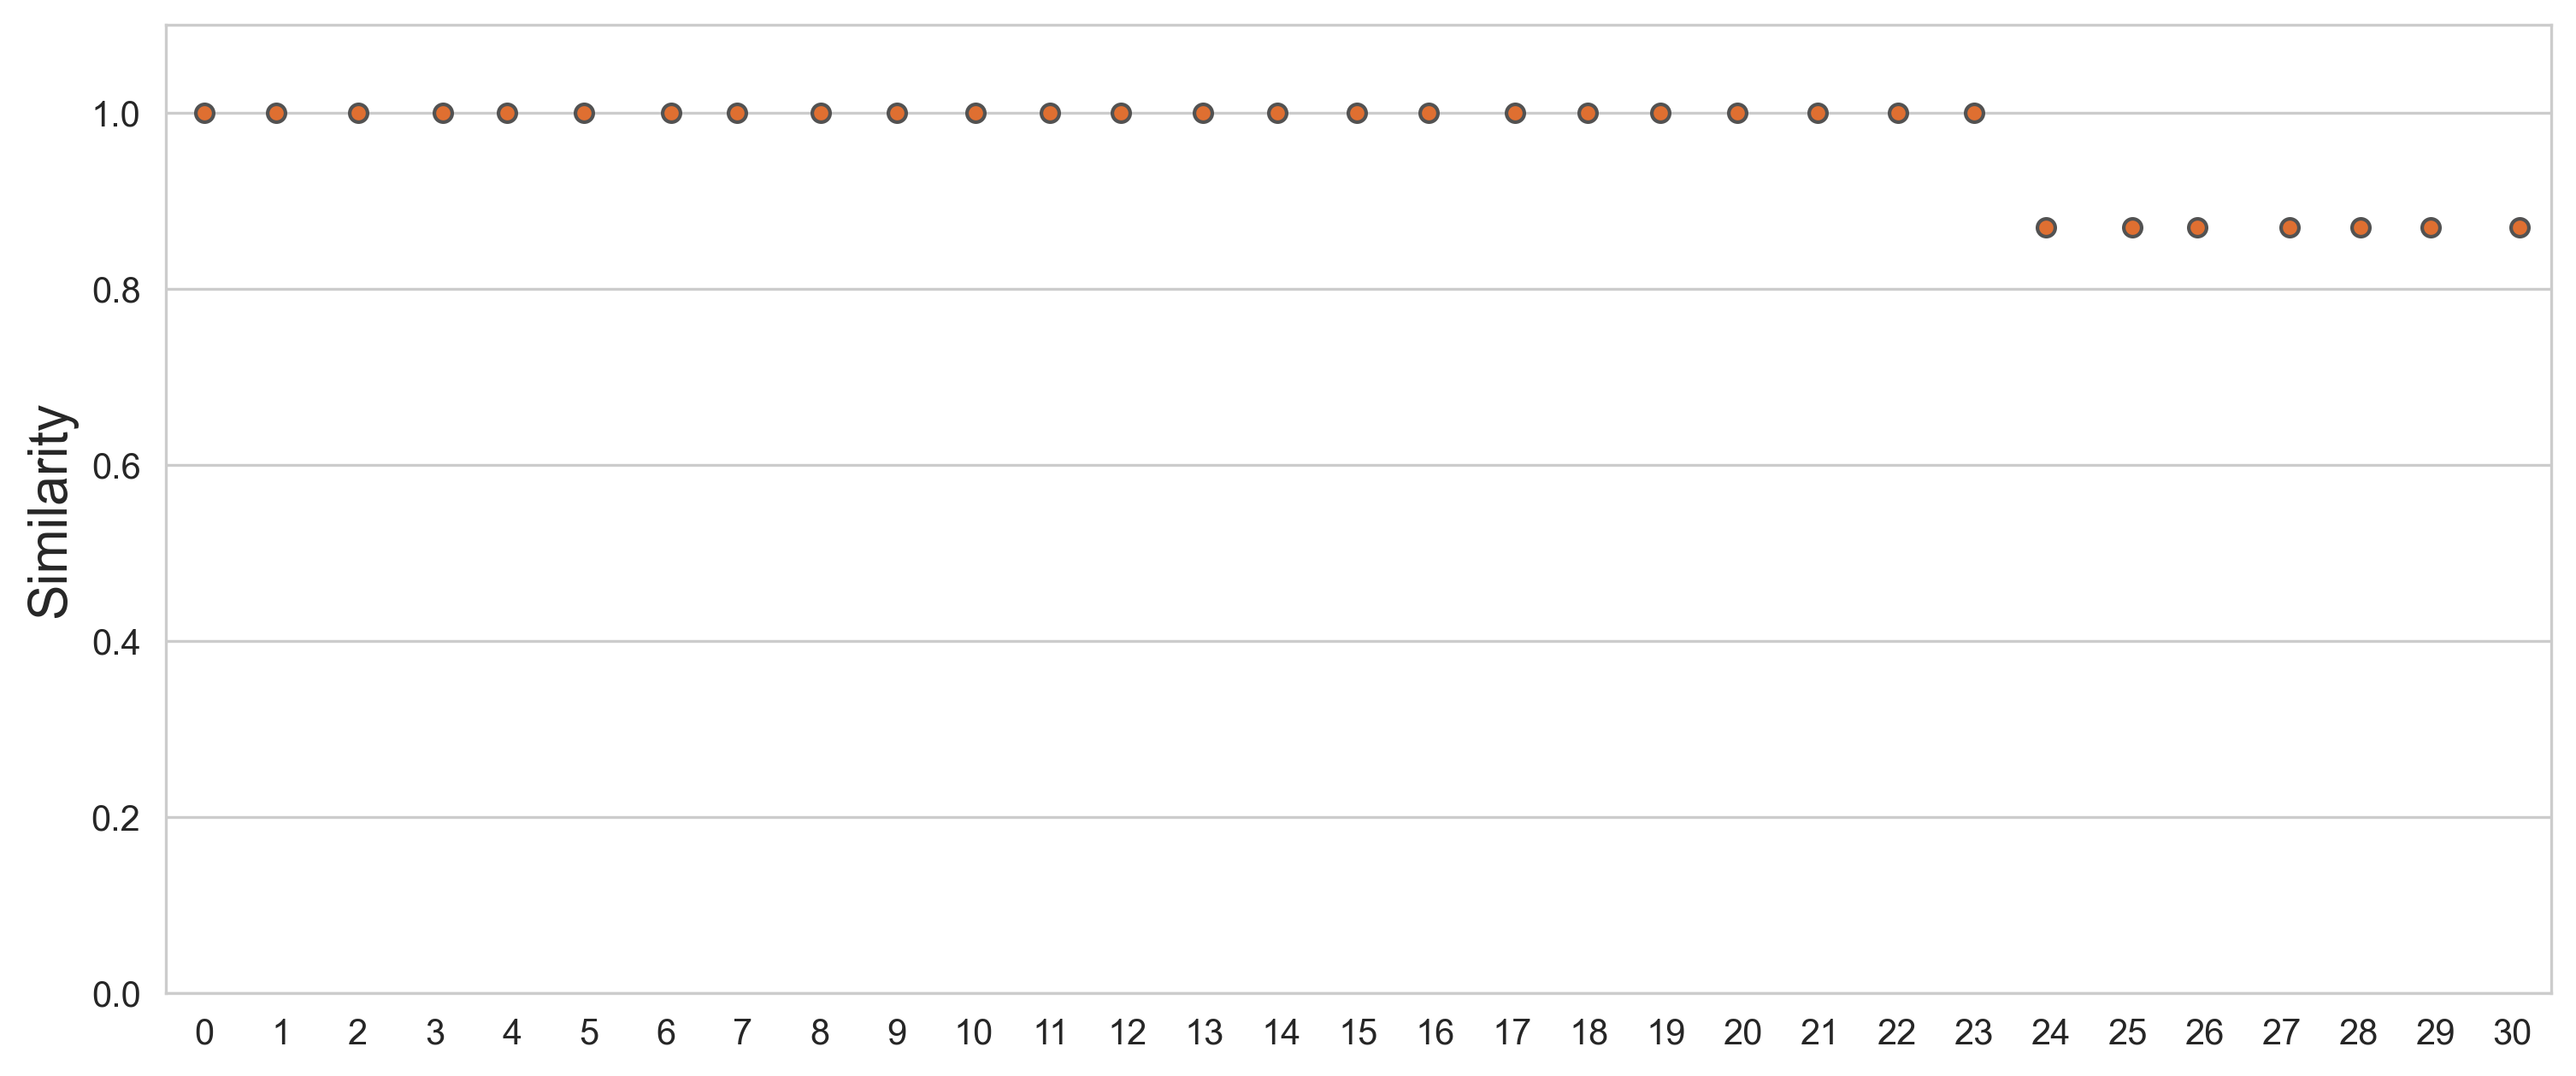

In [23]:
xData = [*range(len(seqSimilarityList))]
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)
sns.set_style("whitegrid")
sns.stripplot(x=xData, y=seqSimilarityList, linewidth=1.0, color=colorA)
ax.set_ylabel("Similarity", size=15)
ax.set_ylim(0,1.1)

In [24]:
# # Test cutter A
# repeatPositionListA = seqA.getRepeatPositionList()
# dfamA = DfamEvaluation(repeatPositionListA)
# repeatPositionLookupDicA = dfamA.positionBucketClassifier()
# dfamPositionListA = dfamA.getDfamPositionList()
# dfamPositionLookupDicA = dfamA.positionBucketClassifier()
# DRrepeatMatchListA, DRmatchedFamilyAccListA, DRmatchedFamilyNameListA = dfamA.checkDfamMatchWithRepeat()

In [25]:
# totalLen = len(DRrepeatMatchListA)
# matchLenA = len(list(filter(lambda x: x, DRrepeatMatchListA)))
# ratio = matchLenA / totalLen
# print(f"matchCount:{matchLenA}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [26]:
# # Test cutter B
# repeatPositionListB = seqB.getRepeatPositionList()
# dfamB = DfamEvaluation(repeatPositionListB)
# repeatPositionLookupDicB = dfamB.positionBucketClassifier()
# dfamPositionListB = dfamB.getDfamPositionList()
# dfamPositionLookupDicB = dfamB.positionBucketClassifier()
# DRrepeatMatchListB, DRmatchedFamilyAccListB, DRmatchedFamilyNameListB = dfamB.checkDfamMatchWithRepeat()

In [27]:
# totalLen = len(DRrepeatMatchListB)
# matchLenB = len(list(filter(lambda x: x, DRrepeatMatchListB)))
# ratio = matchLenB / totalLen
# print(f"matchCount:{matchLenB}\tdfamCount:{totalLen}\tRatio:{ratio}")

In [28]:
# total = 597
# middle = matchLenA+matchLenB - total
# plt.figure(linewidth=10, facecolor="white", dpi=1200)
# # plt.figure(linewidth=10, facecolor="white")
# v = venn2(subsets = (matchLenA-middle, matchLenB-middle, middle), set_labels = (f'CutterA - {cutterA} ', f'CutterB - {cutterB}'), set_colors=(colorA, colorB))
# plt.show()
